<a href="https://colab.research.google.com/github/karthik12s/Speech-Emotion-Recognition/blob/main/RAVDESS_CAPSULE_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Capsule Net Model Training**

In [ ]:
import pickle

In [ ]:
!pip install keras==2.1.6
# !pip install tensorflow==1.7.0

     |████████████████████████████████| 348kB 5.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
from tensorflow.keras.layers import Dense,Dropout,Activation,Multiply,BatchNormalization, Flatten,TimeDistributed,LSTM

In [ ]:
#Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`


import keras.backend as K
import tensorflow as tf
from tensorflow.keras import initializers, layers, models


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='random_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = (layers.Conv1D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d'))(inputs)
    outputs = (layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape'))(output)
    return (layers.Lambda(squash, name='primarycap_squash'))(outputs)

Using TensorFlow backend.


3.1 Capsule Net Model

In [ ]:
def Caps1Net(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)
    x1 = x
    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv1D(filters=128, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    #decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    #decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod((input_shape)), activation='sigmoid',input_dim=16*n_class))
    decoder.add(layers.Reshape(target_shape=(input_shape), name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x1, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x1, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x1, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model

In [ ]:
import numpy as np

In [ ]:
model, eval_model, manipulate_model = Caps1Net(input_shape=(58,1),
                                                  n_class=8,
                                                  routings=3)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [ ]:
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
# Image(retina=True, filename='model.png')

3.2 Model Summary

In [ ]:
model.summary()#

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 58, 1)]      0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 50, 128)      1280        input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv1D)      (None, 21, 256)      295168      conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 672, 8)       0           primarycap_conv2d[0][0]          
______________________________________________________________________________________________

3.3 Loss Function Definition

In [ ]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

3.4 Training the model

In [ ]:
def train(model, data, epochs, epoch_size_frac=1.0):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    start = datetime.today()
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'out_caps': 'accuracy'})
    (x_train, y_train), (x_test, y_test) = data
    print(type(x_test))
    print(type([[x_test, y_test],[y_test, x_test]]))
    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint(
        'weights-{epoch:02d}.h5',
        save_best_only=True, 
        save_weights_only=True, 
        verbose=False)
    lr_decay = callbacks.LearningRateScheduler(
        schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # compile the model
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics=['accuracy'])

    
    # Training without data augmentation:
    hist = model.fit([x_train, y_train], [y_train, x_train], batch_size=50, epochs=50,
              validation_data=([x_test, y_test], [y_test, x_test]))
    

    '''# -----------------------------------Begin: Training with data augmentation -----------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    hist = model.fit_generator(
                        (x_train, y_train),
                        steps_per_epoch=50,
                        epochs=epochs,
                        verbose=2,
                        validation_data=[[x_test, y_test], 
                                         [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay])'''
    #hist=model.fit(x_train, x_train, batch_size=64, epochs=150, validation_data=(x_test, y_test), callbacks=[log, checkpoint, lr_decay])
    # -----------------------------------End: Training with data augmentation -----------------------------------#

    end = datetime.today()
    
    print("_"*10)
    print("Time Took: {}".format(end - start))
    return hist

3.5 MFCC Visualisation

In [ ]:
import pickle
import matplotlib.pyplot as plt

In [ ]:
#@title
x_train = pickle.load(open('/content/drive/MyDrive/Capsule Nets/mfcc/x_train.p', 'rb'))
x_valid = pickle.load(open('/content/drive/MyDrive/Capsule Nets/mfcc/x_valid.p', 'rb'))
x_test = pickle.load(open('/content/drive/MyDrive/Capsule Nets/mfcc/x_test.p', 'rb'))
y_train = pickle.load(open('/content/drive/MyDrive/Capsule Nets/mfcc/y_train.p', 'rb'))
y_valid = pickle.load(open('/content/drive/MyDrive/Capsule Nets/mfcc/y_valid.p', 'rb'))
y_test = pickle.load(open('/content/drive/MyDrive/Capsule Nets/mfcc/y_test.p', 'rb'))

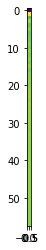

In [ ]:
plt.imshow((x_train[3]).reshape(58,1))

In [ ]:
X_train = x_train
X_test = x_test

In [ ]:
data=(X_train, y_train), (X_test, y_test)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
from datetime import datetime 
from numpy.random import seed


In [ ]:
hist = train(model=model, 
             epochs= 30,#50,
             data=data, 
             epoch_size_frac = 1)

<class 'numpy.ndarray'>
<class 'list'>
Epoch 1/50
130/130 [==============================] - 27s 70ms/step - loss: 3.5429 - capsnet_loss: 0.8070 - decoder_loss: 5471.7942 - capsnet_accuracy: 0.1258 - decoder_accuracy: 0.0000e+00 - val_loss: 3.2350 - val_capsnet_loss: 0.5300 - val_decoder_loss: 5409.9727 - val_capsnet_accuracy: 0.1300 - val_decoder_accuracy: 0.0000e+00
Epoch 2/50
130/130 [==============================] - 8s 64ms/step - loss: 3.1899 - capsnet_loss: 0.4949 - decoder_loss: 5390.0245 - capsnet_accuracy: 0.1719 - decoder_accuracy: 0.0000e+00 - val_loss: 3.1711 - val_capsnet_loss: 0.4672 - val_decoder_loss: 5407.9238 - val_capsnet_accuracy: 0.2634 - val_decoder_accuracy: 0.0000e+00
Epoch 3/50
130/130 [==============================] - 8s 64ms/step - loss: 3.1808 - capsnet_loss: 0.4572 - decoder_loss: 5447.0998 - capsnet_accuracy: 0.2868 - decoder_accuracy: 0.0000e+00 - val_loss: 3.1517 - val_capsnet_loss: 0.4487 - val_decoder_loss: 5406.1284 - val_capsnet_accuracy: 0.3026 - 

In [ ]:
#@title


In [ ]:
#@title
# import pickle
# history = pickle.load(open('/content/drive/MyDrive/Capsule Nets/history.p','rb'))

In [ ]:
#@title
# a=hist.history

In [ ]:
#@title
##import pickle
#pickle.dump(a,open('/content/drive/MyDrive/Capsule Nets/history.p','wb'))

3.6 Loss & Accuracy Curves

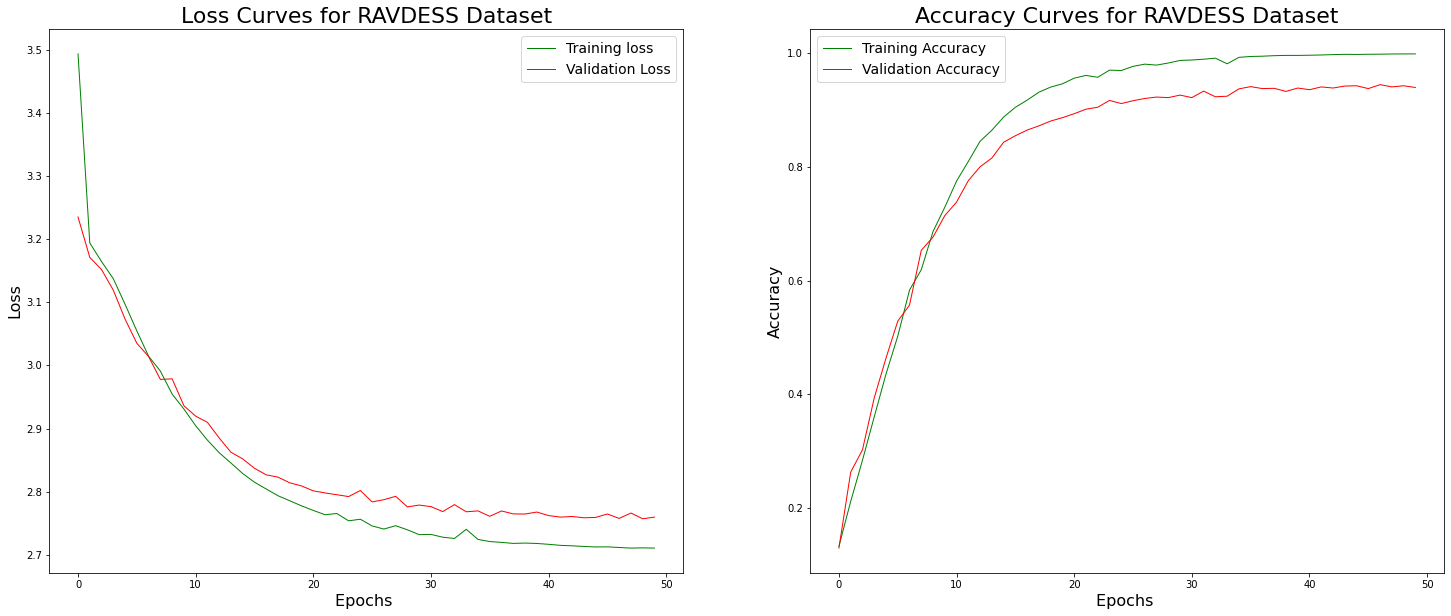

In [ ]:
  # Loss Curves
#history = hist
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history['loss'],'-g',linewidth=1.0)
plt.plot(history['val_loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves for RAVDESS Dataset',fontsize=22)
plt.savefig('Loss_curves.png')
# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history['capsnet_accuracy'],'-g',linewidth=1.0)
plt.plot(history['val_capsnet_accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves for RAVDESS Dataset',fontsize=22)
plt.savefig('Accuracy_curves.png')
plt.show()

In [ ]:
abc = np.zeros(np.shape(y_test))

3.7 Model Prediction

In [ ]:
y_pred, x_recon = model.predict([x_test,abc], batch_size=100)

In [ ]:
y2,x2 = model.predict([x_train[0:2],np.array([0,0])])

In [ ]:
y_train[0:2]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.]])

In [ ]:
y2.round(2)

array([[1.  , 0.  , 0.03, 0.03, 0.14, 0.03, 0.09, 0.01],
       [0.03, 0.01, 0.1 , 0.11, 0.95, 0.  , 0.09, 0.  ]], dtype=float32)

In [ ]:
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

Test acc: 0.939484126984127


# **Code ends here!!**

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
em = ['ANG','SUR','HAP','CALM','FEAR','SAD','NEU','DIS']

In [ ]:
y_test_em = []
for i in range(len(y_test)):
  a = list(y_test[i])
  y_test_em.append(em[a.index(max(a))])

In [ ]:
pred_em = []
for i in range(len(y_pred)):
  a = list(y_pred[i])
  pred_em.append(em[a.index(max(a))])

In [ ]:
multilabel_confusion_matrix(y_test_em, pred_em,labels=['ANG','SUR','HAP','CALM','FEAR','SAD','NEU','DIS'])

array([[[1727,    8],
        [  17,  264]],

       [[1730,   12],
        [  15,  259]],

       [[1711,   14],
        [  19,  272]],

       [[1767,    8],
        [  12,  229]],

       [[1733,   20],
        [  12,  251]],

       [[1713,   28],
        [  17,  258]],

       [[1871,   16],
        [  12,  117]],

       [[1738,   16],
        [  18,  244]]])

In [ ]:
np.shape(y_test_em)

(269,)

In [ ]:
res = confusion_matrix(y_test_em, pred_em,labels=['ANG','SUR','HAP','CALM','FEAR','SAD','NEU','DIS'])

In [ ]:
res

array([[264,   1,   2,   1,   1,   1,   2,   9],
       [  1, 259,   3,   0,   1,   6,   0,   4],
       [  3,   4, 272,   1,   6,   2,   2,   1],
       [  0,   0,   2, 229,   0,   4,   6,   0],
       [  2,   3,   3,   0, 251,   2,   1,   1],
       [  0,   2,   1,   3,   9, 258,   1,   1],
       [  0,   2,   1,   2,   1,   6, 117,   0],
       [  2,   0,   2,   1,   2,   7,   4, 244]])

In [ ]:
res1=list(res)

In [ ]:
res

,ANG,SUR,HAP,CALM,FEAR,SAD,NEU,DIS
ANG,264,1,2,1,1,1,2,9
SUR,1,259,3,0,1,6,0,4
HAP,3,4,272,1,6,2,2,1
CALM,0,0,2,229,0,4,6,0
FEAR,2,3,3,0,251,2,1,1
SAD,0,2,1,3,9,258,1,1
NEU,0,2,1,2,1,6,117,0
DIS,2,0,2,1,2,7,4,244


In [ ]:
l= []
for i in range(8):
  l.append(np.sum(res1[i]))

In [ ]:
l = np.array(l).reshape(8,1)

In [ ]:
res = (res/l).round(2)

In [ ]:
import pandas as pd
res = pd.DataFrame(res,index = ['ANG','SUR','HAP','CALM','FEAR','SAD','NEU','DIS'],columns = ['ANG','SUR','HAP','CALM','FEAR','SAD','NEU','DIS'])

In [ ]:
res.to_csv('Confusion_matrix.csv',index=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

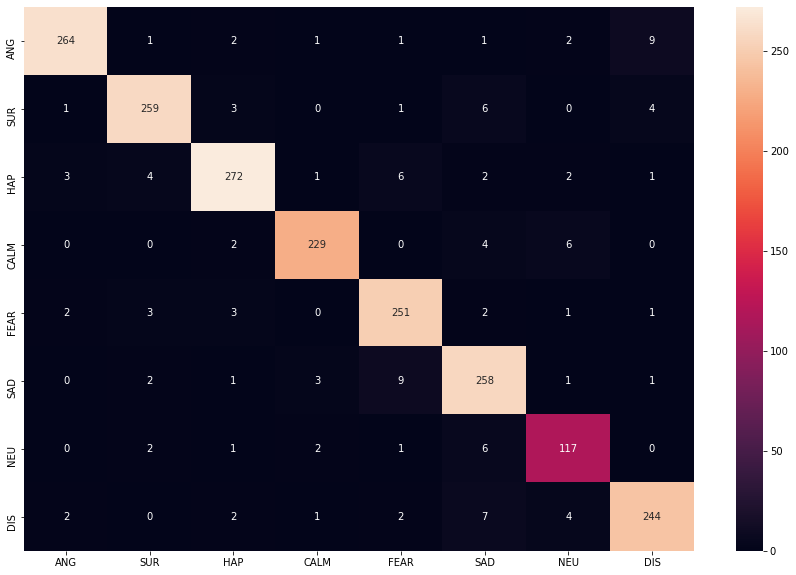

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))  
fi = sns.heatmap(res, annot=True ,ax=ax,fmt='g' )
fi = fi.get_figure()
fi.savefig('out.png')

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_test_em, pred_em,labels=['ANG','SUR','HAP','CALM','FEAR','SAD','NEU','DIS'],average='weighted')

0.939645373277762

In [ ]:
res1 = np.array(res1)

In [ ]:
s=0
for i in range(8):
  for j in range(i+1):
    s = s + res1[i][j]
t = 0
for i in range(8):
  t = t + res1[i][i]
t

1957

In [ ]:
s1=0
for i in range(8):
  for j in range(i,8):
    s1 = s1 + res1[i][j]
s1

1953

In [ ]:
prec = t/s1
rec = t/s

In [ ]:
print("F1 Score is ",(2*prec*rec)/(rec+prec))

F1 Score is  0.9687979539641944


In [ ]:
print('Recall is',t/s1)

Recall is 0.9697900665642601


In [ ]:
print('Presision is ',t/s)

Presision is  0.9678078691875319


In [ ]:
#model.save('/content/drive/MyDrive/Capsule Nets/capsulenet_RAVDESS_93.h5')

In [ ]:
import pickle

In [ ]:
X = pickle.load(open('/content/drive/MyDrive/Capsule Nets/mfcc/BERLIN_X.p','rb'))
Y = pickle.load(open('/content/drive/MyDrive/Capsule Nets/mfcc/BERLIN_Y.p','rb'))

In [ ]:
import tensorflow

In [ ]:
def load_custom_model(model_path):
  from tensorflow.keras.utils import CustomObjectScope
  from tensorflow.keras.models import load_model
  with CustomObjectScope({'CapsuleLayer': CapsuleLayer,'Mask': Mask, 'Length': Length,'margin_loss': margin_loss}):
    return load_model(model_path)

In [ ]:
model = load_custom_model('/content/drive/MyDrive/Capsule Nets/capsulenet_RAVDESS_93.h5')

In [ ]:
import numpy as np

In [ ]:
abc = np.zeros((np.shape(Y1)[0]))

In [ ]:
y_pred,x2 = model.predict([X,abc])

In [ ]:
Y1[3000]

array([0., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
y_pred[3000].round(2)

array([0.03, 0.89, 0.1 , 0.01, 0.18, 0.03, 0.03, 0.01], dtype=float32)

In [ ]:
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(Y1, 1))/Y1.shape[0])

Test acc: 0.2072142857142857


In [ ]:
import librosa

In [ ]:
def extract_features(data):
    
    result = np.array([])
    
    #mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=42) #42 mfcc so we get frames of ~60 ms
    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)
     
    return result

In [ ]:
data,sr = librosa.load('/content/a01.wav')

In [ ]:
data = extract_features(data)

In [ ]:
data = np.array([data,data])

In [ ]:
a,b = model.predict([data,np.array([0,0])])

In [ ]:
a.round(2)

array([[0.15, 0.  , 0.05, 0.05, 0.01, 0.02, 0.01, 0.05],
       [0.15, 0.  , 0.05, 0.05, 0.01, 0.02, 0.01, 0.05]], dtype=float32)